In [46]:
from collections import Counter
from torch import nn
from sklearn.metrics import classification_report
import matplotlib.pyplot as ply
import torch
import numpy as np
from fastai.vision import *
from fastai.metrics import *
np.random.seed(7)
torch.cuda.manual_seed_all(7)
plt.style.use('ggplot')

In [5]:
image_transformation = get_transforms(do_flip=True, flip_vert=True, 
                      max_lighting=0.3, max_warp=0.3, max_rotate=20., max_zoom=0.05)
len(image_transformation)

2

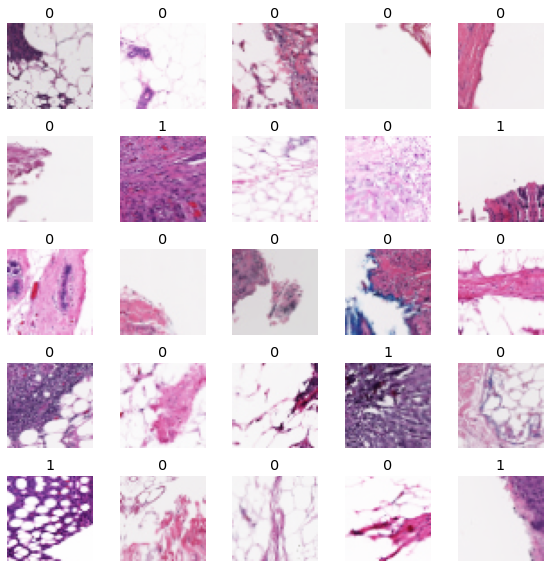

In [61]:
dataset_route = '/content/drive/My Drive/cancer detection/'
Image_pixel_data = ImageDataBunch.from_folder(dataset_route, ds_tfms=image_transformation, valid_pct=0.2,
                                  size=48, bs=128).normalize(imagenet_stats)

Image_pixel_data.show_batch(rows=5, figsize=(8,8))

In [8]:
Image_pixel_data.label_list

LabelLists;

Train: LabelList (2405 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
1,1,1,1,1
Path: /content/drive/My Drive/cancer detection;

Valid: LabelList (601 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
1,0,0,0,0
Path: /content/drive/My Drive/cancer detection;

Test: None

In [14]:
# Training set
training_dataset_counter = Counter(Image_pixel_data.train_ds.y)
training_dataset_counter.most_common()

[(Category 0, 1976), (Category 1, 429)]

In [15]:
# Validation set
validating_dataset_counter = Counter(Image_pixel_data.valid_ds.y)
validating_dataset_counter.most_common()

[(Category 0, 468), (Category 1, 133)]

In [17]:
weight_initialization = [0.4, 1]
class_weights=torch.FloatTensor(weight_initialization).cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,time
0,1.049981,0.554983,0.770383,20:25
1,0.890308,0.369630,0.853577,00:51
2,0.730118,0.335445,0.861897,00:08
3,0.627478,0.292240,0.895175,00:07
4,0.559132,0.286536,0.896839,00:07


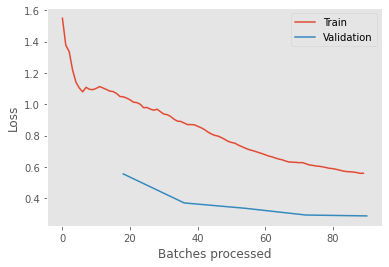

In [19]:
modal = cnn_learner(Image_pixel_data, models.resnet50, metrics=[accuracy]).to_fp16()
modal.loss_func = nn.CrossEntropyLoss(weight=class_weights)
modal.fit_one_cycle(5);
modal.recorder.plot_losses()

In [20]:
# Saving the model
modal.save('Cancer_detection_ResNetV-50_stage-1')

In [21]:
# Model's final validation loss and accuracy
modal.validate()

[0.2865359, tensor(0.8968)]

In [23]:
modal.validate(modal.data.train_dl)

[0.35724944, tensor(0.8633)]

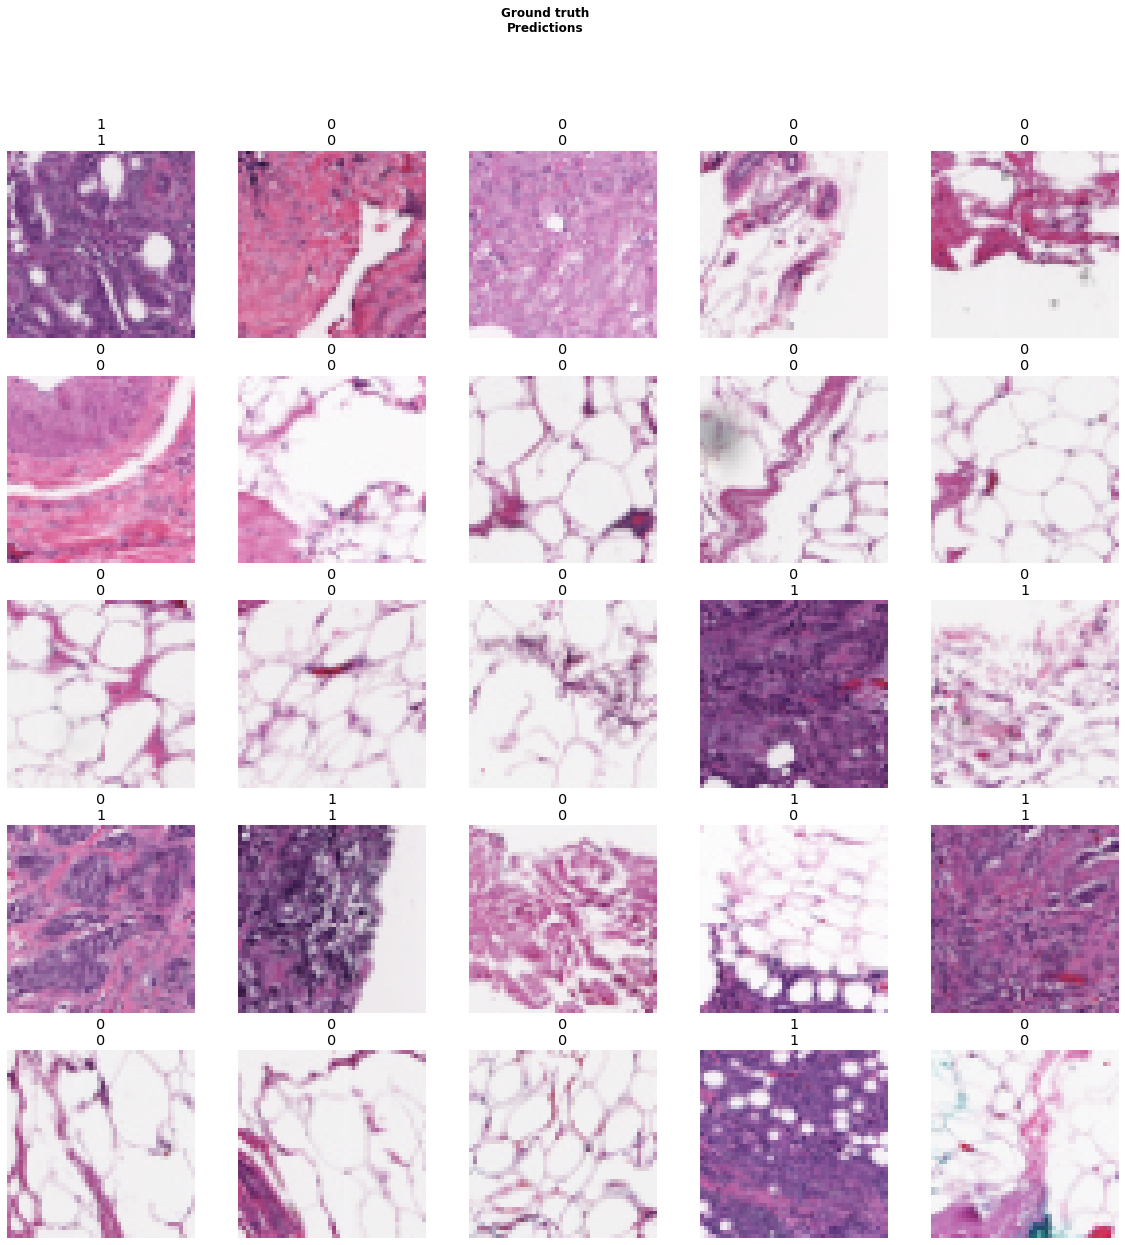

In [25]:
# Looking at model's results
modal.show_results(rows=5)

In [56]:
Classify_images = ClassificationInterpretation.from_learner(modal)

losses,idxs = Classify_images.top_losses()

len(Image_pixel_data.valid_ds)==len(losses)==len(idxs)

True

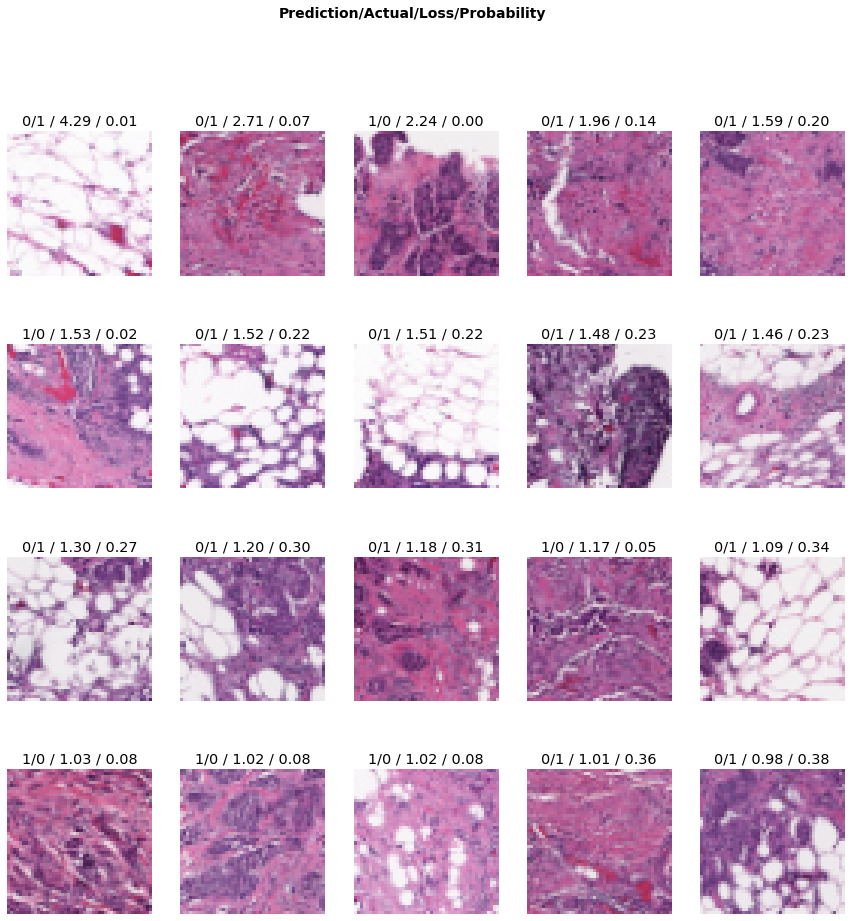

In [30]:
Classify_images.plot_top_losses(20, figsize=(15,15), heatmap=False)

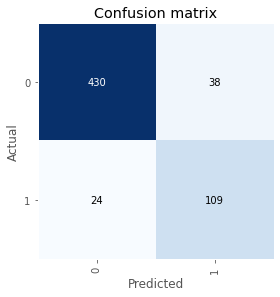

In [31]:
Classify_images.plot_confusion_matrix()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


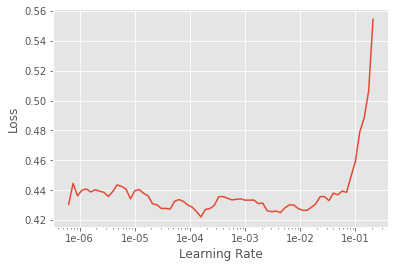

In [57]:
modal.lr_find();
modal.recorder.plot()

In [58]:
modal.unfreeze()
modal.fit_one_cycle(2, max_lr=slice(1e-04, 1e-05))

epoch,train_loss,valid_loss,accuracy,time
0,0.414393,0.291463,0.896839,00:07
1,0.406833,0.285362,0.895175,00:08


In [59]:
# Save model
modal.save('Cancer_detection_ResNetV-50_stage-2')

In [24]:
# Looking at the classification report 
print(return_classification_report(modal))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       468
           1       0.77      0.84      0.81       133

    accuracy                           0.91       601
   macro avg       0.86      0.89      0.87       601
weighted avg       0.91      0.91      0.91       601



In [60]:
modal.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 24, 24]         9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 24, 24]         128        True      
______________________________________________________________________
ReLU                 [64, 24, 24]         0          False     
______________________________________________________________________
MaxPool2d            [64, 12, 12]         0          False     
______________________________________________________________________
Conv2d               [64, 12, 12]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 12, 12]         128        True      
______________________________________________________________________
Conv2d               [64, 12, 12]         36,864     True      
___________________________________________________

In [26]:
modal.export('breast-cancer-rn50.pkl')